In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
import zipfile, pathlib, shutil
zip_path = "mastercard.zip"
extract_to = pathlib.Path("data/mastercard")

with zipfile.ZipFile(zip_path) as zf:
  zf.extractall(extract_to)

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/data/mastercard/Mastercard_stock_history.csv')
df.sort_values('Date', inplace = True)
print(df.head())


                        Date      Open      High       Low     Close  \
0  2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985   
1  2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336   
2  2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   
3  2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   
4  2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   

      Volume  Dividends  Stock Splits  
0  395343000        0.0           0.0  
1  103044000        0.0           0.0  
2   49898000        0.0           0.0  
3   30002000        0.0           0.0  
4   62344000        0.0           0.0  


In [ ]:
close  = df['Close'].values
print(close)
print(close.shape)
close = close.reshape(-1, 1)
print(close.shape)

[  4.19798517   4.1003356    4.01546669 ... 527.64001465 531.98999023
 528.35498047]
(4733,)
(4733, 1)


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(close, test_size = 0.2, shuffle = False)
print(train.shape)
print(test.shape)

(3786, 1)
(947, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(train)
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)
print(train)

[[  4.19798517]
 [  4.1003356 ]
 [  4.01546669]
 ...
 [356.29821777]
 [357.45303345]
 [355.5642395 ]]
[[  4.19798517]
 [  4.1003356 ]
 [  4.01546669]
 ...
 [356.29821777]
 [357.45303345]
 [355.5642395 ]]


In [ ]:
from torch.utils.data import Dataset
window = 30
class stockdataset(Dataset):
  def __init__(self, series, window):
    self.series = torch.tensor(series, dtype = torch.float32)
    self.window = window
  def __len__(self):
    return len(self.series)-self.window

  def __getitem__(self, idx):
    x = self.series[idx:idx+self.window]
    y = self.series[idx+self.window]

    return x, y.squeeze()

train_dataset = stockdataset(train_scaled, window)
test_dataset = stockdataset(test_scaled, window)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 64, layers = 2):
    super().__init__()
    self.rnn = nn.RNN(input_size = 1, hidden_size = hidden_size, num_layers = layers, batch_first = True, dropout = 0.2)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, h = self.rnn(x)
    #print(out.size())
    x = self.linear(out[:,-1,:]).squeeze(-1)
    return x


model = RNN().to(device)
optimizer   = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train(); run_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        run_loss += loss.item() * X.size(0)
    return run_loss / len(loader.dataset)

for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}: loss={loss:.4f}")

Epoch 1: loss=0.0134
Epoch 2: loss=0.0007
Epoch 3: loss=0.0006
Epoch 4: loss=0.0005
Epoch 5: loss=0.0004
Epoch 6: loss=0.0004
Epoch 7: loss=0.0003
Epoch 8: loss=0.0005
Epoch 9: loss=0.0003
Epoch 10: loss=0.0004


tensor(-0.0156, device='cuda:0')


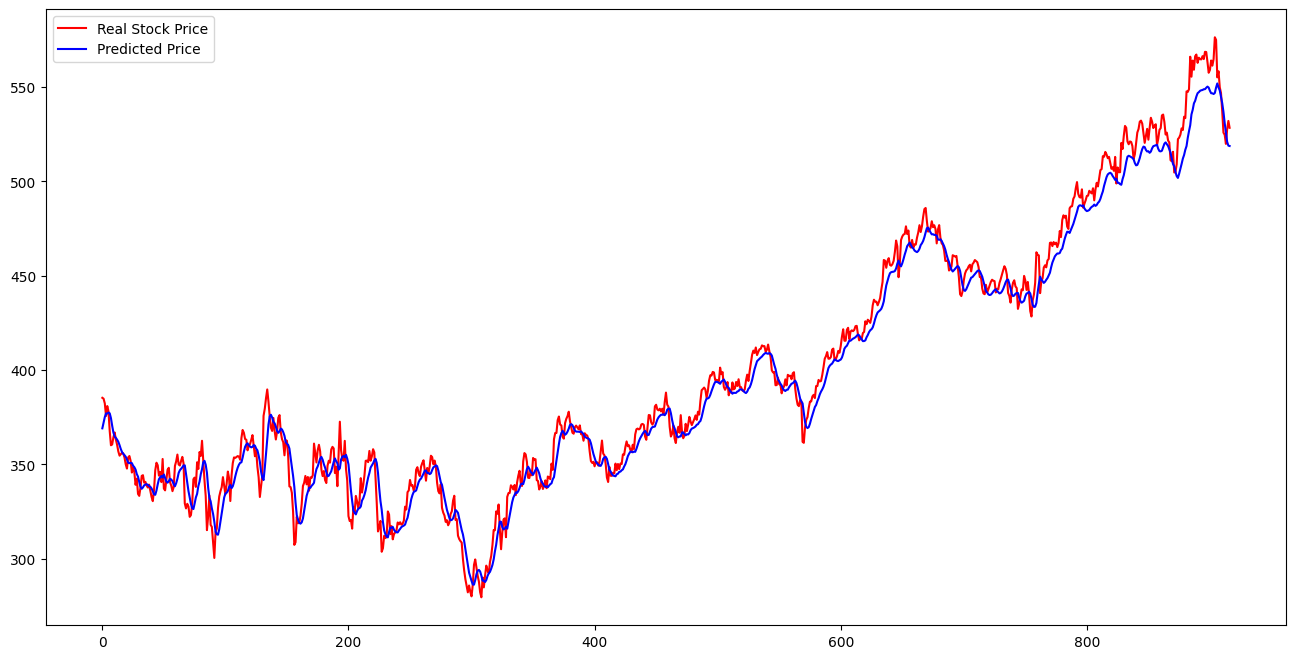

In [ ]:
import matplotlib.pyplot as plt
def evaluate_RNN(model, loader):
  model.eval()
  total = 0
  with torch.no_grad():
    preds = []
    true = []
    for X, y in loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      preds = np.append(preds, pred.cpu().numpy())
      true = np.append(true, y.cpu().numpy())
      mse = pred**2 - y**2
      total += torch.sum(mse)
  return preds, true, total/len(loader.dataset)

preds, true, mse = evaluate_RNN(model, test_loader)
print(mse)

preds_unscaled = scaler.inverse_transform(preds.reshape(-1,1))
true_unscaled = scaler.inverse_transform(true.reshape(-1,1))

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(true_unscaled, color = 'red', label = 'Real Stock Price')
ax.plot(preds_unscaled, color = 'blue', label = 'Predicted Price')
plt.legend()


In [ ]:
import zipfile, pathlib, shutil
zip_path = "movies.zip"
extract_to = pathlib.Path("data/movies")

with zipfile.ZipFile(zip_path) as zf:
  zf.extractall(extract_to)

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/data/movies/IMDB Dataset.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X = df['review'].values
y = df['sentiment'].values
y = np.array([1 if label == 'positive' else 0 for label in y])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
print(x_train.shape)
print(x_test.shape)

(40000,)
(10000,)


In [ ]:
print(x_train[0])

A very interesting entertainment, with the charm of the old movies. Tarzan faces the greatest perils without hesitation if the moment requires it, and we all enjoy with him his success.The most insteresting for me is a man without special powers facing the problems and beating them just with human skills (he was a great swimmer and had a great shout)


In [ ]:
import re
def clean_text(text):
  text = text.lower()

  text = re.sub(r"[^\w\s]", '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+',' ', text)
  return text

x_train = [clean_text(text) for text in x_train]
x_test = [clean_text(text) for text in x_test]
print(x_train[0])




a very interesting entertainment with the charm of the old movies tarzan faces the greatest perils without hesitation if the moment requires it and we all enjoy with him his successthe most insteresting for me is a man without special powers facing the problems and beating them just with human skills he was a great swimmer and had a great shout


In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

example = "the quick brown fox jumps over the lazy dog"
tokens = tokenizer.tokenize(example)
print(tokens)
token_ids = tokenizer.encode(example)
print(token_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
[101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102]


In [ ]:
1 1 1 1 1 1 1 0 0 0 0

In [ ]:
def tokenize_text(text, tokenizer, max_length = 200):
  encodings = tokenizer(list(text), max_length = max_length, padding = 'max_length', truncation = True, return_tensors = 'pt')
  return encodings['input_ids'], encodings['attention_mask']

train_ids, train_attention= tokenize_text(x_train, tokenizer)
test_ids, test_attention = tokenize_text(x_test, tokenizer)





In [ ]:
print(train_ids[0])
print(train_attention[0])

tensor([  101,  1037,  2200,  5875,  4024,  2007,  1996, 11084,  1997,  1996,
         2214,  5691, 24566,  5344,  1996,  4602,  2566, 12146,  2302, 13431,
         2065,  1996,  2617,  5942,  2009,  1998,  2057,  2035,  5959,  2007,
         2032,  2010,  3112, 10760,  2087, 16021,  3334,  4355,  2075,  2005,
         2033,  2003,  1037,  2158,  2302,  2569,  4204,  5307,  1996,  3471,
         1998,  6012,  2068,  2074,  2007,  2529,  4813,  2002,  2001,  1037,
         2307, 13361,  1998,  2018,  1037,  2307, 11245,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
X, y

In [ ]:
from torch.utils.data import Dataset
class IMDBDataset(Dataset):
  def __init__(self, ids, attention, labels):
    self.ids = ids
    self.attention = attention
    self.labels = labels
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    self.labels = torch.tensor(self.labels, dtype = torch.long)
    return self.ids[idx], self.attention[idx], self.labels[idx]

train_dataset = IMDBDataset(train_ids, train_attention, y_train)
test_dataset = IMDBDataset(test_ids, test_attention, y_test)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
64, 500

In [ ]:
vocab_size = tokenizer.vocab_size
pad_size = tokenizer.pad_token_id
print(vocab_size)
print(pad_size)
class LSTM(nn.Module):
  def __init__(self, hidden_size = 128, layers = 2, num_classes=2):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx = pad_size)
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers = layers, batch_first = True, dropout = 0.2)
    self.linear = nn.Linear(hidden_size, num_classes)

  def forward(self, ids, attention):
    embeddings = self.embedding(ids)
    #print(embeddings.size())
    out, h = self.lstm(embeddings)
    #print(out.size())
    lengths = torch.sum(attention, dim = 1)
    last_idx = (lengths-1).clamp_min(0)
    get_idx = torch.arange(out.size(0)).to(device)
    features = out[get_idx, last_idx]
    x = self.linear(features)
    return x

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


30522
0


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train(); run_loss = 0
    for ids, att, y in loader:
        ids, att, y = ids.to(device), att.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(ids, att)
        loss = criterion(pred, y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        run_loss += loss.item() * ids.size(0)
    return run_loss / len(loader.dataset)

for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}: loss={loss:.4f}")

/tmp/ipython-input-418314269.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(self.labels, dtype = torch.long)


Epoch 1: loss=0.6314
Epoch 2: loss=0.4443
Epoch 3: loss=0.2636
Epoch 4: loss=0.1993
Epoch 5: loss=0.1523
Epoch 6: loss=0.1182
Epoch 7: loss=0.0825
Epoch 8: loss=0.0627


KeyboardInterrupt: 

In [ ]:
def evaluate(model, loader):
  model.eval()
  correct = 0
  with torch.no_grad():
    for ids, att, y in loader:
      ids, att, y = ids.to(device), att.to(device), y.to(device)
      pred = model(ids, att)
      prediction = pred.argmax(dim = 1)
      correct += (prediction == y).sum().item()
  return correct/len(loader.dataset)
evaluate(model, test_loader)


/tmp/ipython-input-418314269.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(self.labels, dtype = torch.long)


0.8824